In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorsys
from matplotlib.colors import to_rgb, to_hex
import matplotlib.patches as mpatches

# Constants
optimizers = ['Postgres', 'NEO', 'BAO', 'LOGER', 'FASTgres', 'LERO']
# optimizers = ['Postgres', 'NEO', 'BAO', 'LOGER', 'FASTgres']
RUNS = 3  # Number of runs for each optimizer

from pathlib import Path
try:
    # Works when running from a .py file
    REPO_ROOT = Path(__file__).resolve()
except NameError:
    # Fallback for notebooks — use current working directory
    REPO_ROOT = Path.cwd().resolve()
while REPO_ROOT.name != "Learned-Optimizers-Benchmarking-Suite" and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent

base_dir = REPO_ROOT / 'experiments/experiment5/'

sub_experiments = {
    'unseen_queries': {
        'query_distribution': {
            'job_dynamic': os.path.join(base_dir, '5.1', 'distribution_generalization', 'job_d'),
            'job_extended': os.path.join(base_dir, '5.1', 'distribution_generalization', 'job_extended'),
            'job_light': os.path.join(base_dir, '5.1', 'distribution_generalization', 'job_light'),
            'job_synthetic': os.path.join(base_dir, '5.1', 'distribution_generalization', 'job_synthetic'),
        },
        'query_complexity': os.path.join(base_dir, '5.1', 'complexity_generalization'),
        'query_selectivity': os.path.join(base_dir, '5.1', 'selectivity_generalization')
    },
    'schema_shift': {
        'workload_specific_schema_shift': os.path.join(base_dir, '5.2', 'job'),
        'structure_shift': os.path.join(base_dir, '5.2', 'ssb'),
    },
    'data_distribution_shift': os.path.join(base_dir, '5.3', 'stack_sampled')
}
# Each experiment dir has a train and a test dir, test dir contains subdirectories for each run,  then each run contains subdirectories for each queryID, then each queryID contains subdirectories for each optimizer

In [47]:
def process_query(records, category, subcategory, dataset, run, query_id, query_path):
    for optimizer in optimizers:
        if optimizer == 'Postgres':
            plan_file = os.path.join(query_path, 'classic_qep.json')
        else:
            plan_file = os.path.join(query_path, optimizer, f'{query_id}_{optimizer.lower()}_plan.json')

        if not os.path.exists(plan_file):
            if dataset == "selectivity_generalization" and optimizer == ['LOGER']:
                print(f"Plan file {plan_file} does not exist, skipping optimizer {optimizer}.")
            # if optimizer not in ['LERO', 'NEO']:
            #     print(f"Plan file {plan_file} does not exist, skipping optimizer {optimizer}.")
            continue

        try:
            with open(plan_file, 'r') as f:
                data = json.load(f)
                if isinstance(data, list):
                    data = data[1] if optimizer == 'BAO' else data[0]

            exec_time = float(data.get('Execution Time', 0)) / 1000.0
            inf_time = None

            if optimizer == 'Postgres':
                inf_time = float(data.get('Planning Time', 0)) / 1000.0
            elif optimizer in ['BAO', 'LERO']:
                inf_time = float(data.get('Planning Time', 0)) / 1000.0
            elif optimizer in ['LOGER', 'NEO', 'FASTgres']:
                metrics_file = os.path.join(query_path, optimizer, f'{query_id}_{optimizer.lower()}_metrics.json')
                if os.path.exists(metrics_file):
                    with open(metrics_file, 'r') as mf:
                        metrics_data = json.load(mf)
                        if optimizer in ['LOGER', 'NEO']:
                            inf_time = float(metrics_data.get('inference_time', 0)) / 1000.0
                        else:
                            inf_time = float(metrics_data.get('forward_time', 0)) / 1000.0

            records.append({
                'category': category,
                'subcategory': subcategory,
                'dataset': dataset,
                'run': run,
                'query_id': query_id,
                'optimizer': optimizer,
                'latency_sec': exec_time,
                'inference_time_sec': inf_time,
                'model_trained_year': 'N/A',
                'evaluated_data_year': 'N/A'
            })
        except Exception:
            print(f"Error processing file {plan_file} for optimizer {optimizer} in query {query_id}.")
            continue

def process_experiment(records, category, subcategory, dataset, test_dir, has_runs=True):
    if dataset not in ["job_dynamic", "job_extended", "job_light", "job_synthetic"]:
        test_dir = os.path.join(test_dir, 'test')

    if not os.path.exists(test_dir):
        print(f"Test directory {test_dir} does not exist, skipping.")
        return

    run_dirs = [f'run{i+1}' for i in range(RUNS)] if has_runs else ['']
    for run in run_dirs:
        run_path = os.path.join(test_dir, run) if run else test_dir
        if not os.path.exists(run_path):
            print(f"Run path {run_path} does not exist, skipping.")
            continue

        if dataset == "selectivity_generalization":
            for query_template in os.listdir(run_path):
                query_template_path = os.path.join(run_path, query_template)
                if not os.path.isdir(query_template_path):
                    continue
                for query_id in os.listdir(query_template_path):
                    query_path = os.path.join(query_template_path, query_id)
                    if not os.path.isdir(query_path):
                        continue
                    # Remove the % char from query_id
                    query_id = query_id.replace('%', '')
                    process_query(records, category, subcategory, dataset, run, query_template + "_" + query_id, query_path)
        else:
            for query_id in os.listdir(run_path):
                query_path = os.path.join(run_path, query_id)
                if not os.path.isdir(query_path):
                    continue

                if dataset == "job_synthetic":
                    loger_path = os.path.join(query_path, 'LOGER')
                    if not os.path.exists(loger_path):
                        print(f"LOGER directory {loger_path} does not exist, skipping.")
                        continue

                process_query(records, category, subcategory, dataset, run, query_id, query_path)

def process_data_distribution_shift(records, category, subcategory, base_path):
    actual_test_root = os.path.join(base_path, 'test')  # e.g. stack_sampled/test
    if not os.path.exists(actual_test_root):
        print(f"Test directory {actual_test_root} does not exist for {category}/{subcategory}, skipping.")
        return

    # Iterate through query directories directly (e.g., q1__q1-001, q16__f67c..., etc.)
    for query_id in os.listdir(actual_test_root):
        query_path = os.path.join(actual_test_root, query_id)
        if not os.path.isdir(query_path):
            continue

        # -----------------------------
        # Process Postgres outputs
        # -----------------------------
        postgres_files = [
            f for f in os.listdir(query_path)
            if f.startswith('qep_') and f.endswith('.json') and not f.endswith('.sql_1.json')
        ]
        for pg_file in postgres_files:
            evaluated_data_year = pg_file.replace('qep_', '').replace('.json', '')
            plan_file = os.path.join(query_path, pg_file)
            try:
                with open(plan_file, 'r') as f:
                    data = json.load(f)
                exec_time = float(data.get('Execution Time', 0)) / 1000.0
                inf_time = float(data.get('Planning Time', 0)) / 1000.0
                records.append({
                    'category': category,
                    'subcategory': subcategory,
                    'dataset': 'stack',
                    'run': f"Postgres_evaluated_on_{evaluated_data_year}",
                    'query_id': query_id,
                    'optimizer': 'Postgres',
                    'latency_sec': exec_time,
                    'inference_time_sec': inf_time,
                    'model_trained_year': 'N/A',
                    'evaluated_data_year': evaluated_data_year
                })
            except Exception as e:
                print(f"Error processing Postgres file {plan_file} for query {query_id}: {e}")

        # -----------------------------
        # Process Learned Optimizers
        # -----------------------------
        for model_trained_dir in os.listdir(query_path):
            if not model_trained_dir.endswith('_models'):
                continue

            model_trained_year = model_trained_dir.replace('_models', '')
            model_path = os.path.join(query_path, model_trained_dir)
            if not os.path.isdir(model_path):
                continue

            for optimizer in optimizers:
                if optimizer == 'Postgres':
                    continue
                optimizer_path = os.path.join(model_path, optimizer)
                if not os.path.exists(optimizer_path):
                    continue

                for opt_file in os.listdir(optimizer_path):
                    if not (opt_file.endswith('.json.2011') or opt_file.endswith('.json.2015') or opt_file.endswith('.json.2019')):
                        continue

                    evaluated_data_year = opt_file.split('.')[-1]
                    if '_plan.json' in opt_file:
                        plan_file = os.path.join(optimizer_path, opt_file)
                        try:
                            with open(plan_file, 'r') as f:
                                data = json.load(f)
                                if isinstance(data, list):
                                    if optimizer == 'BAO':
                                        data = data[1]
                                    else:
                                        data = data[0]

                            exec_time = float(data.get('Execution Time', 0)) / 1000.0
                            inf_time = None

                            metrics_file_base = opt_file.replace('_plan.json', '_metrics.json')
                            metrics_file = os.path.join(optimizer_path, metrics_file_base)

                            if os.path.exists(metrics_file):
                                with open(metrics_file, 'r') as mf:
                                    metrics_data = json.load(mf)
                                    if optimizer in ['LOGER', 'NEO']:
                                        inf_time = float(metrics_data.get('inference_time', 0)) / 1000.0
                                    elif optimizer == 'FASTgres':
                                        inf_time = float(metrics_data.get('forward_time', 0)) / 1000.0
                                    elif optimizer in ['BAO', 'LERO']:
                                        inf_time = float(data.get('Planning Time', 0)) / 1000.0
                            else:
                                if optimizer in ['BAO', 'LERO']:
                                    inf_time = float(data.get('Planning Time', 0)) / 1000.0

                            records.append({
                                'category': category,
                                'subcategory': subcategory,
                                'dataset': 'stack',
                                'run': f"{model_trained_year}_models_evaluated_on_{evaluated_data_year}",
                                'query_id': query_id,
                                'optimizer': optimizer,
                                'latency_sec': exec_time,
                                'inference_time_sec': inf_time,
                                'model_trained_year': model_trained_year,
                                'evaluated_data_year': evaluated_data_year
                            })
                        except Exception as e:
                            print(f"Error processing plan file {plan_file} for optimizer {optimizer} in query {query_id} (model year {model_trained_year}): {e}")
                            continue

# Collect everything
def collect_all_data():
    records = []
    for category, subcats in sub_experiments.items():
        print(f'Processing category: {category}')
        if category == 'data_distribution_shift':
            process_data_distribution_shift(records, category, 'data_distribution_shift', subcats)
        elif isinstance(subcats, dict):
            for subcat, val in subcats.items():
                print(f'  Processing subcategory: {subcat}')
                if isinstance(val, dict):
                    for dataset, path in val.items():
                        print(f'    Processing dataset1: {dataset}')
                        no_runs = any(x in dataset for x in ['job_dynamic', 'job_synthetic'])
                        process_experiment(records, category, subcat, dataset, path, has_runs=not no_runs)
                else:
                    dataset = os.path.basename(val)
                    print(f'    Processing dataset2: {dataset}')
                    process_experiment(records, category, subcat, dataset, val)
        else:
            print(f'Processing dataset3: {subcats}')
            dataset = os.path.basename(subcats)
            process_experiment(records, category, None, dataset, subcats)
    return pd.DataFrame(records)

# Run everything
df = collect_all_data()

Processing category: unseen_queries
  Processing subcategory: query_distribution
    Processing dataset1: job_dynamic
    Processing dataset1: job_extended
Error processing file /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment5/5.1/distribution_generalization/job_extended/run1/e10a/NEO/e10a_neo_plan.json for optimizer NEO in query e10a.
    Processing dataset1: job_light
    Processing dataset1: job_synthetic
LOGER directory /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment5/5.1/distribution_generalization/job_synthetic/692/LOGER does not exist, skipping.
LOGER directory /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment5/5.1/distribution_generalization/job_synthetic/8619/LOGER does not exist, skipping.
LOGER directory /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment5/5.1/distribution_generalization/job_synthetic/282/LOGER does not exist, skip

In [48]:
# Adjust prepare_data to handle the new columns for data_distribution_shift
def prepare_data(df, category, subcategory=None):
    latency_dict, inference_dict = {}, {}
    subset = df[df['category'] == category]
    print(f"Preparing data for category: {category}, subcategory: {subcategory if subcategory else 'None'}")
    if subcategory:
        subset = subset[subset['subcategory'] == subcategory]

    if category == 'data_distribution_shift':
        # Get all unique model trained years (excluding N/A initially to build structure)
        trained_years = [y for y in subset['model_trained_year'].unique() if y != 'N/A']
        
        # Get all unique evaluated data years (these will be the X-axis points)
        evaluated_years = sorted(subset['evaluated_data_year'].unique())

        # Extract Postgres data once, as it's independent of model_trained_year
        postgres_data_latency = {}
        postgres_data_inference = {}
        pg_subset = subset[subset['optimizer'] == 'Postgres']
        for eval_year in evaluated_years:
            pg_eval_subset = pg_subset[pg_subset['evaluated_data_year'] == eval_year]
            postgres_data_latency[eval_year] = pg_eval_subset['latency_sec'].sum()
            inference_sum = pg_eval_subset['inference_time_sec'].sum()
            postgres_data_inference[eval_year] = inference_sum if pd.notna(inference_sum) else 0

        # Now populate the main dictionaries, adding Postgres to each trained_year group
        for model_trained_year in trained_years:
            model_year_str = str(model_trained_year)
            latency_dict[model_year_str] = {}
            inference_dict[model_year_str] = {}

            df_model_year = subset[subset['model_trained_year'] == model_trained_year]
            
            for evaluated_data_year in evaluated_years: # Iterate through all possible evaluated years
                latency_dict[model_year_str][evaluated_data_year] = {}
                inference_dict[model_year_str][evaluated_data_year] = {}

                # Add Postgres data to this group
                latency_dict[model_year_str][evaluated_data_year]['Postgres'] = postgres_data_latency.get(evaluated_data_year, 0)
                inference_dict[model_year_str][evaluated_data_year]['Postgres'] = postgres_data_inference.get(evaluated_data_year, 0)
                
                # Add LQO data for the current model_trained_year and evaluated_data_year
                df_eval_year_lqos = df_model_year[(df_model_year['evaluated_data_year'] == evaluated_data_year) & 
                                                  (df_model_year['optimizer'] != 'Postgres')]
                
                for optimizer in df_eval_year_lqos['optimizer'].unique():
                    df_optimizer = df_eval_year_lqos[df_eval_year_lqos['optimizer'] == optimizer]
                    latency_dict[model_year_str][evaluated_data_year][optimizer] = df_optimizer['latency_sec'].sum()
                    inference_sum = df_optimizer['inference_time_sec'].sum()
                    inference_dict[model_year_str][evaluated_data_year][optimizer] = inference_sum if pd.notna(inference_sum) else 0
        
        return latency_dict, inference_dict

    else: # Standard processing for other categories (group by dataset and run)
        for dataset in subset['dataset'].unique():
            latency_dict[dataset], inference_dict[dataset] = {}, {}
            df_dataset = subset[subset['dataset'] == dataset]
            
            for run_id in df_dataset['run'].unique():
                df_run = df_dataset[df_dataset['run'] == run_id]
                latency_dict[dataset][run_id] = {}
                inference_dict[dataset][run_id] = {}
                
                for optimizer in df_run['optimizer'].unique():
                    df_optimizer = df_run[df_run['optimizer'] == optimizer]
                    latency_dict[dataset][run_id][optimizer] = df_optimizer['latency_sec'].sum()
                    inference_sum = df_optimizer['inference_time_sec'].sum()
                    inference_dict[dataset][run_id][optimizer] = inference_sum if pd.notna(inference_sum) else 0
        return latency_dict, inference_dict

In [49]:
[latency_dict, inference_dict] = prepare_data(df, 'unseen_queries', 'query_distribution')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

[latency_dict, inference_dict] = prepare_data(df, 'unseen_queries', 'query_complexity')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

[latency_dict, inference_dict] = prepare_data(df, 'unseen_queries', 'query_selectivity')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

[latency_dict, inference_dict] = prepare_data(df, 'schema_shift', 'workload_specific_schema_shift')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

[latency_dict, inference_dict] = prepare_data(df, 'schema_shift', 'structure_shift')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

Preparing data for category: unseen_queries, subcategory: query_distribution
Latency Data: {'job_dynamic': {'': {'Postgres': 21670.037438, 'NEO': 251259.87059300003, 'BAO': 18257.013340999998, 'FASTgres': 23507.426825000002, 'LOGER': 30027.555754999998}}, 'job_extended': {'run1': {'Postgres': 63.149829, 'NEO': 2708.4502029999994, 'BAO': 123.58670799999999, 'LOGER': 175.893324, 'FASTgres': 89.231494}, 'run2': {'Postgres': 61.652665000000006, 'NEO': 293.90659700000003, 'BAO': 118.275272, 'LOGER': 154.908701, 'FASTgres': 70.084738}, 'run3': {'Postgres': 61.082817, 'NEO': 291.199102, 'BAO': 116.83438100000001, 'LOGER': 154.616988, 'FASTgres': 68.298178}}, 'job_light': {'run1': {'Postgres': 553.8719369999999, 'NEO': 1525.157934, 'BAO': 489.08883599999984, 'LOGER': 1361.6302809999995, 'FASTgres': 577.8316910000001}, 'run2': {'Postgres': 526.9512650000001, 'NEO': 1389.695038, 'BAO': 482.03560799999997, 'LOGER': 1337.289042, 'FASTgres': 525.1945000000001}, 'run3': {'Postgres': 518.031331999999

In [50]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import colorsys, os
import matplotlib.ticker as ticker
from matplotlib.colors import to_rgb, to_hex

# --- Color palette and hatching ---
optimizer_colors = {
    'Postgres': '#1f77b4',
    'NEO': '#ff7f0e',
    'BAO': '#2ca02c',
    'LOGER': '#d62728',
    'FASTgres': '#9467bd',
    # 'LERO': "#cbcd5a"
}
patterns = {
    'Postgres': '',
    'NEO': '//',
    'BAO': '\\\\',
    'LOGER': '||',
    'FASTgres': '--',
    # 'LERO': 'OO'
}

def adjust_lightness(color, amount=0.5):
    """Lighten/darken a color by scaling luminance."""
    try:
        c = colorsys.rgb_to_hls(*to_rgb(color))
        return to_hex(colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2]))
    except:
        return color

def format_sci(num, decimals=2):
    """Format number as ×10^n with LaTeX style."""
    if num == 0:
        return "0"
    exp = int(np.floor(np.log10(abs(num))))
    base = num / 10**exp
    return f"${base:.{decimals}f} \\times 10^{{{exp}}}$"

# ------------------------------------------------------
# Per-benchmark view: benchmarks on X-axis
# ------------------------------------------------------
def create_stacked_bar_plot(latency_dict, inference_dict, title="Execution + Inference Time", log_scale=True, output_dir="plots"):
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams.update({'font.size': 26})

    benchmarks = list(latency_dict.keys())
    optimizers = list(optimizer_colors.keys())
    n_optimizers = len(optimizers)

    group_width = 0.95
    bar_width = group_width / n_optimizers
    x = np.arange(len(benchmarks))

    fig, ax = plt.subplots(figsize=(18, 10))
    legend_flags = {"Execution": False, "Inference": False}

    for i, optimizer in enumerate(optimizers):
        offset = (i - n_optimizers / 2) * bar_width + bar_width / 2

        for j, benchmark in enumerate(benchmarks):
            exec_vals = [r.get(optimizer, 0) for r in latency_dict[benchmark].values()]
            inf_vals = [r.get(optimizer, 0) for r in inference_dict[benchmark].values()]
            avg_exec = np.mean(exec_vals) if exec_vals else 0
            avg_inf = np.mean(inf_vals) if inf_vals else 0
            total = avg_exec + avg_inf

            xpos = x[j] + offset
            color = optimizer_colors[optimizer]
            light_color = adjust_lightness(color, 1.3)
            hatch = patterns[optimizer]

            # Bars
            ax.bar(xpos, avg_inf, bar_width, color=light_color, edgecolor="black", hatch=hatch,
                   label="Inference Time" if not legend_flags["Inference"] else "")
            ax.bar(xpos, avg_exec, bar_width, bottom=avg_inf, color=color, edgecolor="black", hatch=hatch,
                   label="Execution Time" if not legend_flags["Execution"] else "")
            legend_flags["Inference"] = legend_flags["Execution"] = True

            # Total time above
            if total > 0:
                ax.text(xpos, total * 1.2,
                        format_sci(total), ha="center", va="bottom", fontsize=24, rotation=90)

            # Speedup vs Postgres
            pg_exec = np.mean([r.get("Postgres", 0) for r in latency_dict[benchmark].values()])
            pg_inf = np.mean([r.get("Postgres", 0) for r in inference_dict[benchmark].values()])
            pg_total = pg_exec + pg_inf if (pg_exec + pg_inf) > 0 else 1e-6

            if optimizer != "Postgres" and total > 0:
                speedup = pg_total / total
                ax.text(xpos, total / 100 if log_scale else -0.1, f"{speedup:.2f}×",
                        ha="center", va="center", fontsize=26, fontweight="bold", rotation=90,
                        bbox=dict(facecolor="white", edgecolor="none", pad=1, alpha=0.9))

    # Axes
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks, fontsize=30)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=30)
    ax.set_ylabel("")

    if log_scale:
        ax.set_yscale("log")
        ax.set_ylim(bottom=1e-2)
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1.0], numticks=10))
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2.0, 5.0], numticks=10))
    else:
        ax.set_ylim(bottom=-0.3)

    # Legend
    optimizer_handles = [mpatches.Patch(facecolor=optimizer_colors[o], edgecolor="black", hatch=patterns[o], label=o)
                         for o in optimizers]
    exec_patch = mpatches.Patch(facecolor="gray", edgecolor="black", label="Execution Time")
    inf_patch = mpatches.Patch(facecolor="lightgray", edgecolor="black", label="Inference Time")

    ax.legend(handles=optimizer_handles + [inf_patch, exec_patch],
              loc="upper center", bbox_to_anchor=(0.5, -0.1),
              ncol=4, fontsize=30, frameon=True, facecolor="white", edgecolor="black", fancybox=True)

    ax.grid(True, axis="y", linestyle="--", alpha=0.7)
    ax.margins(0.02)
    plt.tight_layout(pad=0.0)
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, f"workload_distribution.pdf"), bbox_inches="tight")
    plt.show()

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

## Generalization to Unseen Queries

We assess how well optimizers handle queries that differ structurally and statistically from the training set.

### Query Distribution Generalization

Test of performance on a workload with significantly different feature distribution

We first characterize each workload by aggregating features from its queries (e.g., referenced tables, join patterns, predicate types) and then calculate the dissimilarities using the Jensen-Shannon (JS) Divergence

Train: JOB

Test: JOB-Light, JOB-Extended, JOB-Dynamic and JOB-Synthetic

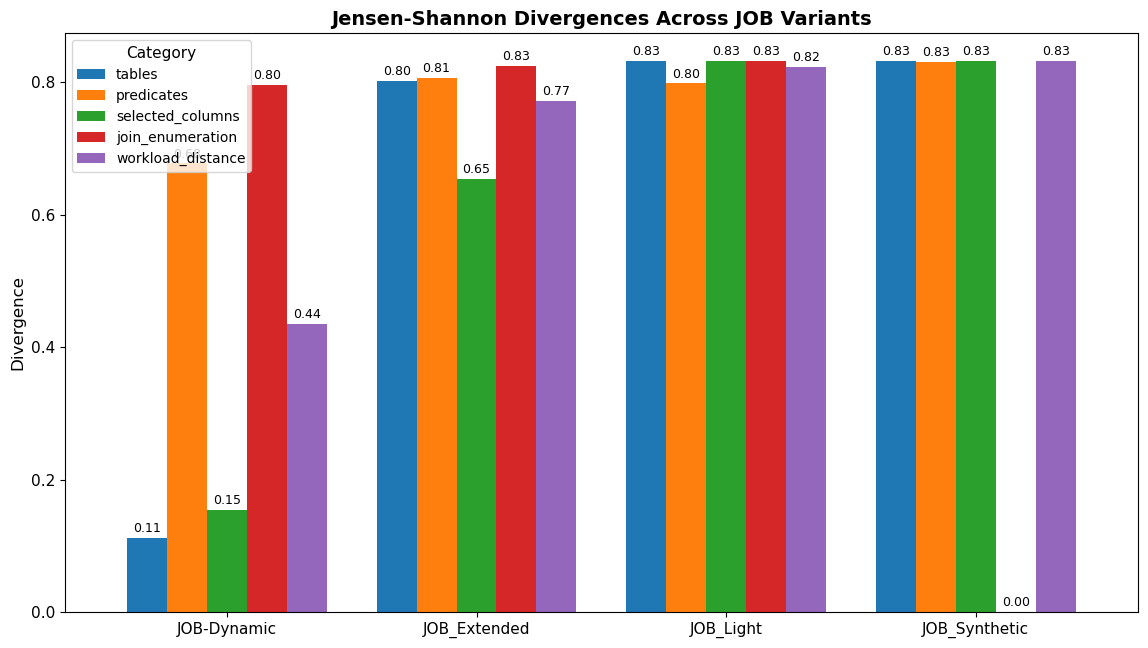

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data
distribution_data = {
    "JOB-Dynamic": {
        "tables": 0.1126,
        "predicates": 0.6779,
        "selected_columns": 0.1549,
        "join_enumeration": 0.7968,
        "workload_distance": 0.4356,
    },
    "JOB_Extended": {
        "tables": 0.8024,
        "predicates": 0.8072,
        "selected_columns": 0.6548,
        "join_enumeration": 0.8255,
        "workload_distance": 0.7725,
    },
    "JOB_Light": {
        "tables": 0.8326,
        "predicates": 0.7986,
        "selected_columns": 0.8326,
        "join_enumeration": 0.8326,
        "workload_distance": 0.8241,
    },
    "JOB_Synthetic": {
        "tables": 0.8326,
        "predicates": 0.8315,
        "selected_columns": 0.8326,
        "join_enumeration": None,
        "workload_distance": None,  # will be calculated
    },
}

# Calculate workload_distance for JOB_Synthetic as the average of available values
synthetic_values = [
    distribution_data["JOB_Synthetic"]["tables"],
    distribution_data["JOB_Synthetic"]["predicates"],
    distribution_data["JOB_Synthetic"]["selected_columns"],
]
distribution_data["JOB_Synthetic"]["workload_distance"] = np.mean(synthetic_values)

# Convert to DataFrame
distribution_df = pd.DataFrame(distribution_data).T

# Plot
ax = distribution_df.plot(kind="bar", figsize=(12, 7), width=0.8)
plt.title("Jensen-Shannon Divergences Across JOB Variants", fontsize=14, weight="bold")
plt.ylabel("Divergence", fontsize=12)
plt.xticks(rotation=0, ha="center", fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Category", fontsize=10, title_fontsize=11)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=9, label_type="edge", padding=2)

plt.tight_layout()
plt.show()



--- Processing JOB Baseline from: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment1/job/test/run3 ---

Successfully added JOB Baseline data to the existing DataFrame.
Preparing data for category: unseen_queries, subcategory: query_distribution
Preparing data for category: baseline, subcategory: job_baseline

Generating plot for Query Distributions with JOB Baseline...


/tmp/ipykernel_1987045/2106116210.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=30)


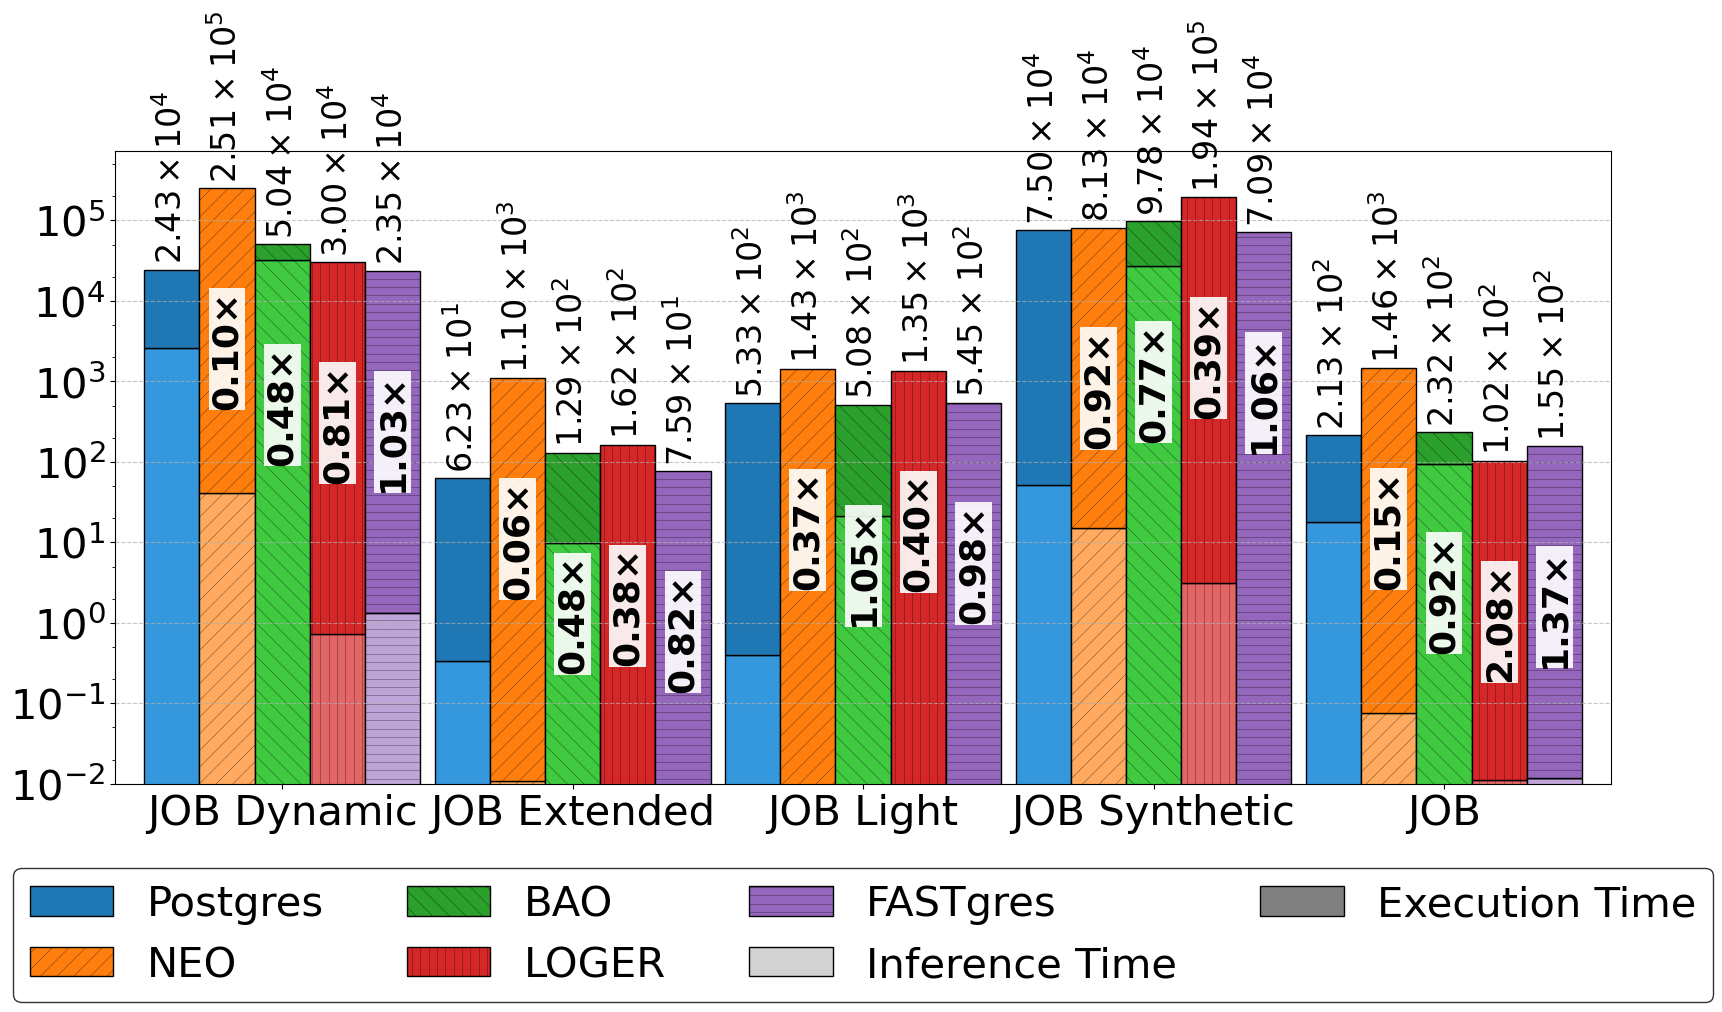

In [ ]:
import os
import json
import pandas as pd

# ==============================================================================
# 1. Define a function to process ONLY the new JOB baseline data
# ==============================================================================
def process_job_baseline(records):
    """
    Processes the JOB baseline data from experiment 1 and appends it to the records list.
    """
    job_baseline_path = f'{REPO_ROOT}/experiments/experiment1/job/test/run3'
    print(f"\n--- Processing JOB Baseline from: {job_baseline_path} ---")

    if not os.path.exists(job_baseline_path):
        print(f"JOB Baseline path not found, skipping.")
        return

    # The dataset name 'JOB Baseline' will be used as the plot label
    dataset_name = 'JOB'
    run_id = 'run3' # As specified in the path

    for query_id in os.listdir(job_baseline_path):
        query_path = os.path.join(job_baseline_path, query_id)
        if not os.path.isdir(query_path):
            continue
        # Use a new, unique category to keep it separate during preparation
        process_query(records, 'baseline', 'job_baseline', dataset_name, run_id, query_id, query_path)

# ==============================================================================
# 2. Run the new processing and combine with the existing DataFrame
# ==============================================================================
# Create a list to hold only the new records
job_baseline_records = []
process_job_baseline(job_baseline_records)

# Convert the new records to a DataFrame
df_job_baseline = pd.DataFrame(job_baseline_records)

# Combine the new DataFrame with your existing one without re-running collection
df_combined = pd.concat([df, df_job_baseline], ignore_index=True)

print("\nSuccessfully added JOB Baseline data to the existing DataFrame.")


# ==============================================================================
# 3. Prepare data and create the plot using the combined DataFrame
# ==============================================================================

# a. Prepare data for the original 'unseen_queries - query_distribution' from the combined DF
lat_dist, inf_dist = prepare_data(df_combined, 'unseen_queries', 'query_distribution')

# b. Prepare data for the new 'baseline - job_baseline' from the combined DF
lat_job, inf_job = prepare_data(df_combined, 'baseline', 'job_baseline')

# c. Merge the dictionaries for plotting. The unpacking operator (**) is perfect for this.
final_latency = {**lat_dist, **lat_job}
final_inference = {**inf_dist, **inf_job}

# d. Optional: Rename keys for prettier plot labels
def rename_keys(d, mapping):
    return {mapping.get(k, k): v for k, v in d.items()}

key_mapping = {
    'job_dynamic': 'JOB Dynamic',
    'job_extended': 'JOB Extended',
    'job_light': 'JOB Light',
    'job_synthetic': 'JOB Synthetic'
}
final_latency = rename_keys(final_latency, key_mapping)
final_inference = rename_keys(final_inference, key_mapping)

# e. Call the original plotting function with the final, combined data
if final_latency and final_inference:
    print("\nGenerating plot for Query Distributions with JOB Baseline...")
    create_stacked_bar_plot(
        final_latency,
        final_inference,
        title='Unseen Queries - Distribution Generalization vs. JOB Baseline'
    )
else:
    print("Could not generate combined plot. Check if data was prepared correctly.")

### Takeaways

- **FASTgres**: more or less matches the perfromance of the classic optimizer across all workloads. 
  - This probably is tied to the fact that even during inference it develops a new decision tree for every new query context it encounters.

- **NEO**: shows massive slowdowns for job_extended and job_light, 2 workloads that have somewhat of a similar distribution, but performs less worse in the case of job_dynamic. Performs fine in the case of JOB-Synthetic
  - This means that the knowledge the model currently has leads it to catastrophic decisions for workloads like job_extended and job_light

- **LOGER**: has a slight degradation only in the case of *job_dynamic*, and major problems with all other workloads (that contain queries whose structure are significantly different than the JOB workload). 
  - This probably means that the Graph Transformer (a embedded neural network used for Query Encoding) struggles to transfer its knowledge on other workloads
  - In none of the cases however does it suffer from catastrophic decisions, since it's utility in the processing pipeline to restrict operators (rather than building a fully-fledged QEP from scratch)

- **BAO**: underperforms overall in all workloads with the exception of *job_light*
  - JOB-Light intuitively resembles a subset of JOB just with less complexity, as it reuses many of its joins and filters. So it is easier for BAO to reuse the hints it already learned cause of 

- **LERO**: Again, like NEO, LERO shows massive slowdowns for job_extended and job_light, 2 workloads that have somewhat of a similar distribution, but performs less worse in the case of job_dynamic. Performs fine in the case of JOB-Synthetic
  - The 2 optimizers share a Value Model so this is to be expected. The variation in performance across workloads also suggests that their slowdowns are not only an outcome of suboptimal learning, but also a product of bad generalization

---

### Query Complexity Generalization

We test the ability of the LOQs to generalize from simple to more complex queries

Train: JOB subset with queries < 10 joins

Test: JOB subset with queries > 10 joins

In [53]:
# create_stacked_bar_plot_per_optimizer(*prepare_data(df, 'unseen_queries', 'query_complexity'), title='Unseen Queries - Complexity')

### Takeaways

- **FASTgres**: Speedup over PostgreSQL
  - Again, this probably is because it develops a new decision tree for every new query context it encounters.
- **NEO, LERO**: Catastrophic decisions probably caused by the increased complexity. 
  - Their Tree-CNN value model learned a function to predict query latency, but this function is only valid for the simple query trees it saw during training.
- **LOGER**: has a slight degradation
  - Again, probably because the Graph Transformer can not transfer the knowledge
- **BAO**: The hints that were learned on the easier complexity did not generalize on the harder testing workload.

---

### Selectivity Generalization

We measure performance when query predicate selectivities are outside the range seen during training

Dataset: Subset of JOB-Synthetic and JOB-Extended, queries with title.production_year filters

Train: Predicates with low selectivity (∼0–20%)

Test: Predicates with high selectivity (∼60–100%)

In [54]:
def create_grouped_bar_plot_by_dimension(latency_dict, inference_dict, title="Performance by Generalization Dimension", log_scale=True, output_dir="plots", dimension="query_distribution"):
    """
    Creates a HORIZONTAL grouped and stacked bar plot.
    Groups on the y-axis are the benchmarks. Bars for each optimizer are drawn horizontally.
    """
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams.update({'font.size': 24}) # Smaller base font size

    benchmarks = list(latency_dict.keys())
    optimizers_in_plot = list(optimizer_colors.keys())
    n_optimizers = len(optimizers_in_plot)

    fig, ax = plt.subplots(figsize=(12, 8)) # Set the desired compact figure size
    
    group_width = 0.9
    bar_height = group_width / n_optimizers
    y = np.arange(len(benchmarks))

    for i, optimizer in enumerate(optimizers_in_plot):
        offset = (i - n_optimizers / 2) * bar_height + bar_height / 2

        for j, benchmark in enumerate(benchmarks):
            exec_vals = [r.get(optimizer, 0) for r in latency_dict[benchmark].values()]
            inf_vals = [r.get(optimizer, 0) for r in inference_dict[benchmark].values()]
            avg_exec = np.mean(exec_vals) if exec_vals else 0
            avg_inf = np.mean(inf_vals) if inf_vals else 0
            total = avg_exec + avg_inf

            ypos = y[j] + offset
            color = optimizer_colors[optimizer]
            light_color = adjust_lightness(color, 1.4)
            hatch = patterns[optimizer]

            ax.barh(ypos, avg_inf, height=bar_height, color=light_color, edgecolor="black", hatch=hatch, align='center')
            ax.barh(ypos, avg_exec, height=bar_height, left=avg_inf, color=color, edgecolor="black", hatch=hatch, align='center')

            # --- ADJUSTED ANNOTATION FONT SIZES ---
            if total > 0:
                ax.text(total * 1.1, ypos, f"{total:.1f}", ha="left", va="center", fontsize=26) # Smaller font

            pg_exec = np.mean([r.get("Postgres", 0) for r in latency_dict[benchmark].values()])
            pg_inf = np.mean([r.get("Postgres", 0) for r in inference_dict[benchmark].values()])
            pg_total = pg_exec + pg_inf if (pg_exec + pg_inf) > 0 else 1e-9

            if optimizer != "Postgres" and total > 0:
                speedup = pg_total / total
                xpos_speedup = avg_inf + avg_exec / 4
                ax.text(
                    xpos_speedup / 1.5, ypos, f"{speedup:.2f}×",
                    ha='center', va='center', fontsize=22, fontweight='bold', color='black', # Smaller font
                    bbox=dict(facecolor='white', edgecolor='none', pad=1.0, alpha=0.85) # Reduced padding
                )

    # --- ADJUSTED AXES AND LABEL FONT SIZES ---
    ax.set_yticks(y)
    plt.xticks(fontsize=30)
    ax.set_yticklabels(benchmarks, fontsize=30) # Smaller font for benchmark names
    # ax.set_xlabel("", fontsize=10) # Smaller font for axis label
    # ax.set_ylabel("", fontsize=10)

    if log_scale:
        ax.set_xscale("log")
        ax.set_xlim(left=1e-1)
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    
    ax.invert_yaxis()

    # --- COMPACT LEGEND ---
    optimizer_handles = [mpatches.Patch(facecolor=optimizer_colors[o], edgecolor="black", hatch=patterns[o], label=o) for o in optimizers_in_plot]
    time_handles = [
        mpatches.Patch(facecolor="gray", edgecolor="black", label="Execution Time"),
        mpatches.Patch(facecolor="lightgray", edgecolor="black", label="Inference Time")
    ]

    # ax.legend(handles=optimizer_handles + time_handles,
    #           loc="upper center", bbox_to_anchor=(0.5, 1.27), # Adjusted position for smaller figure
    #           ncol=4, # 4 columns fits well
    #           fontsize=25, # Smaller legend font
    #           frameon=True, facecolor="white", edgecolor="black", fancybox=True,
    #           handlelength=1.5) # Shorter legend color patches

    ax.grid(True, axis="x", linestyle="--", alpha=0.6)
    
    # Adjust layout to prevent labels/legend from being cut off
    plt.tight_layout()
    ax.margins(0.05)

    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"{dimension}.pdf")
    plt.subplots_adjust(left=0.1, right=0.98, top=0.88, bottom=0.12)
    fig.savefig(plot_filename, bbox_inches="tight")
    print(f"Plot saved to {plot_filename}")
    plt.show()



--- Preparing data for combined plot ---
Preparing data for category: unseen_queries, subcategory: query_complexity
Preparing data for category: unseen_queries, subcategory: query_selectivity
Generating combined plot grouped by dimension...


Plot saved to plots/unseen_queries.pdf


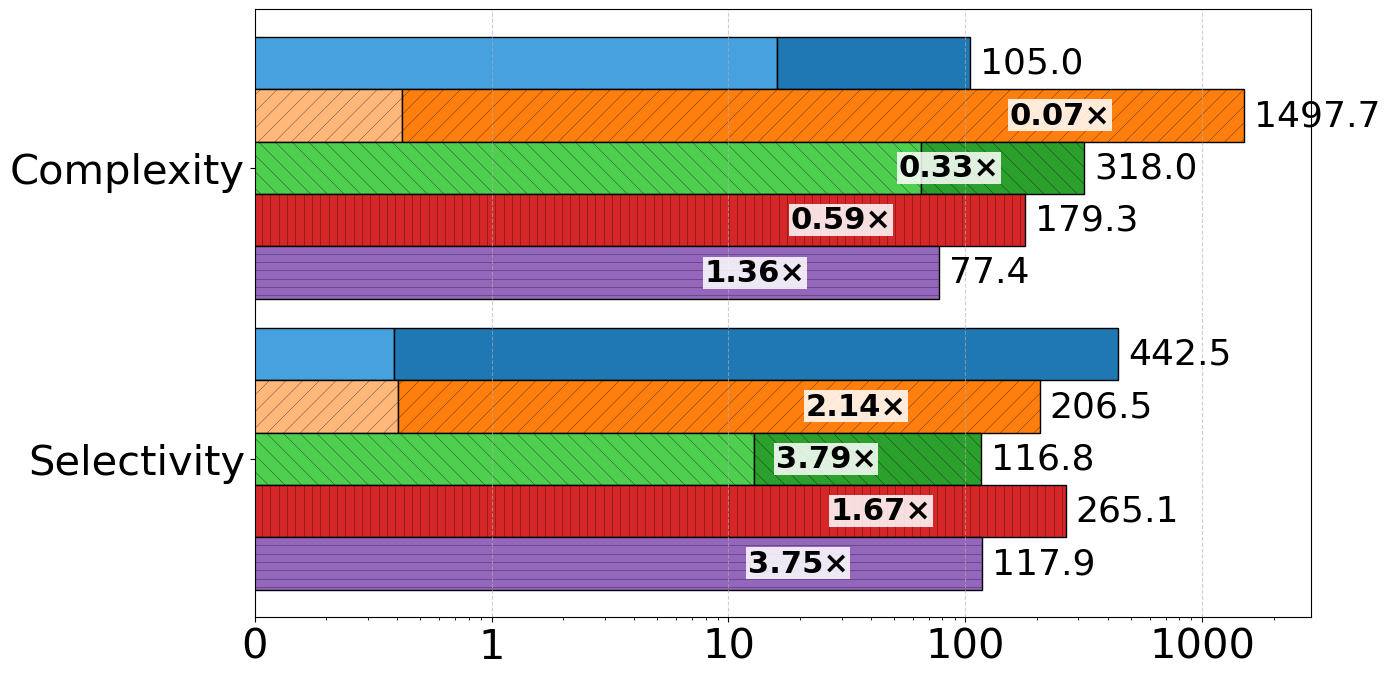

In [55]:
print("\n--- Preparing data for combined plot ---")

# 1. Prepare data for 'query_complexity'
latency_complexity, inference_complexity = prepare_data(df, 'unseen_queries', 'query_complexity')

# 2. Prepare data for 'query_selectivity'
latency_selectivity, inference_selectivity = prepare_data(df, 'unseen_queries', 'query_selectivity')

# 3. Merge the dictionaries, using cleaner names for the plot x-axis
combined_latency = {}
if 'complexity_generalization' in latency_complexity:
    combined_latency['Complexity'] = latency_complexity['complexity_generalization']
if 'selectivity_generalization' in latency_selectivity:
    combined_latency['Selectivity'] = latency_selectivity['selectivity_generalization']

combined_inference = {}
if 'complexity_generalization' in inference_complexity:
    combined_inference['Complexity'] = inference_complexity['complexity_generalization']
if 'selectivity_generalization' in inference_selectivity:
    combined_inference['Selectivity'] = inference_selectivity['selectivity_generalization']

# 4. Call the new plotting function with the combined data
if combined_latency and combined_inference:
    print("Generating combined plot grouped by dimension...")
    create_grouped_bar_plot_by_dimension(
        combined_latency,
        combined_inference,
        title='Unseen Queries: Generalization to Complexity vs. Selectivity',
        dimension='unseen_queries'
    )
else:
    print("Could not generate combined plot because data for complexity or selectivity was not found.")

### Takeaways

- **Postgres**: Struggled very much so, to the point that almost all other LQOs outperformed it. 
  - Probably proves the point about heuristics
- **FASTgres**: Significant speedup over PostgreSQL (3.75x)
- **BAO**: Also a significant speedup over PostgreSQL (3.79x). While BAO doesnt do Query encodings bao includes selectivity info per node on its plan encodings
- The hint-based optimizers showed by far the biggest speedups, suggesting that they learned a cost function relating selectivity to execution time. This probably ties in with the findings of experiment 4.1, where those optimizers where the ones that made drastic and unilateral deviations from the classic optimizer when it comes to scan operators
- **LOGER**: Uncharacteristically low speedup (1.67x, outperformed even by NEO with 2.14x), which again ties with the findings of 4.1 that said that LOGER when it comes to scan operators takes a sometimes conservative approach
  - Also, since the Graph Transormer is outright trained including selectivities in its featurization, the generalization of that knowledge is mayhaps done suboptimally
- **NEO**: Uncharacteristically good performance, appears to deal well with the relationship between selectivity and access path selection. Selectivity is inluded in query encodings so this is not totally unexpected
- **LERO**: Registers a slowdown of 0.5. 
  - It is probably the learning-to-rank paradigm that has overfit in this case, since the TCNN Value Model in the case of NEO appears to work just fine

---

## Adaptability to New Schemas

We evaluate how well optimizers adapt to changes in the database schema

### Workload-Specific Schema Shift

We examine the scenario where the database schema remains the same, however there is a shift in the workload where a table that was never looked up before is actually queried

Train: JOB workload excluding char_name queries

Test: JOB workload with only char_name queries

Preparing data for category: schema_shift, subcategory: workload_specific_schema_shift


Preparing data for category: schema_shift, subcategory: structure_shift
Generating enhanced plot for Schema Shifts...
Plot saved to plots/schema_shift.pdf


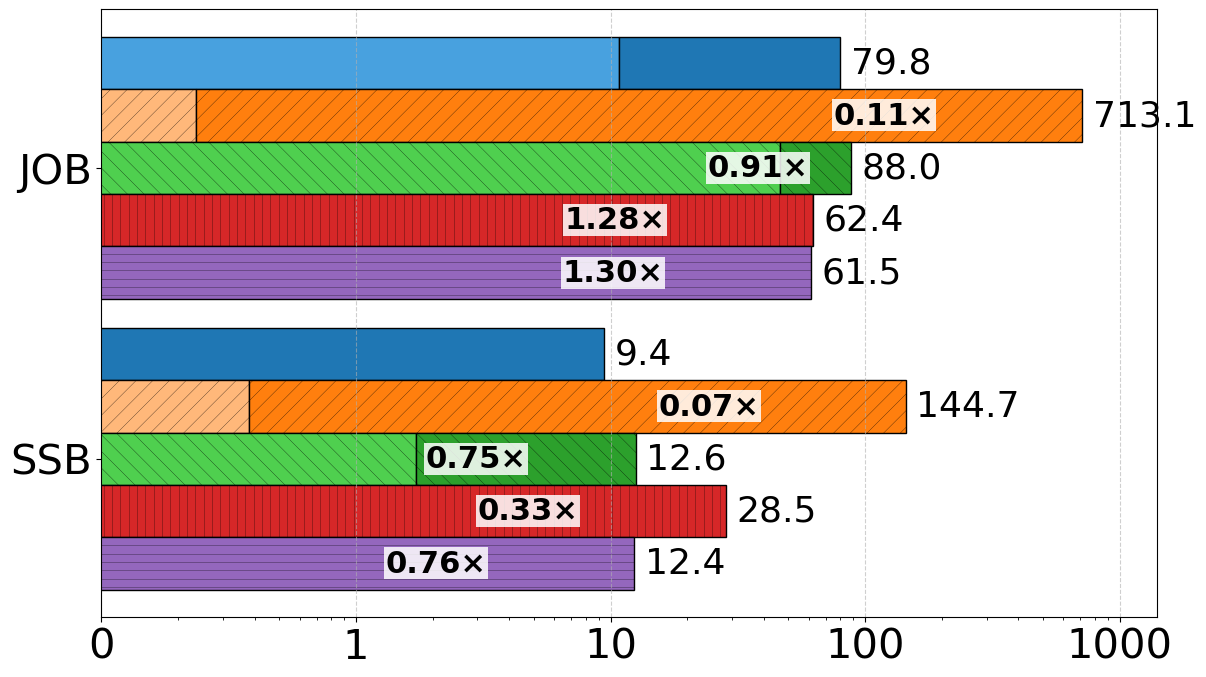

In [56]:
# 1. Prepare data for 'workload_specific_schema_shift' (dataset is 'job')
latency_workload, inference_workload = prepare_data(df, 'schema_shift', 'workload_specific_schema_shift')

# 2. Prepare data for 'structure_shift' (dataset is 'ssb')
latency_structure, inference_structure = prepare_data(df, 'schema_shift', 'structure_shift')

# 3. Merge the dictionaries with cleaner names for the plot x-axis
combined_latency = {}
if 'job' in latency_workload:
    combined_latency['JOB'] = latency_workload['job']
if 'ssb' in latency_structure:
    combined_latency['SSB'] = latency_structure['ssb']

combined_inference = {}
if 'job' in inference_workload:
    combined_inference['JOB'] = inference_workload['job']
if 'ssb' in inference_structure:
    combined_inference['SSB'] = inference_structure['ssb']

# 4. Call the plotting function with the combined Schema Shift data
if combined_latency and combined_inference:
    print("Generating enhanced plot for Schema Shifts...")
    create_grouped_bar_plot_by_dimension(
        combined_latency,
        combined_inference,
        title='Schema Shift: Workload-Specific vs. Structural',
        dimension='schema_shift'
    )
else:
    print("Could not generate combined plot for Schema Shifts. Check if data was loaded correctly.")

In [57]:
# create_stacked_bar_plot_per_optimizer(*prepare_data(df, 'schema_shift', 'workload_specific_schema_shift'), title='Schema Shift - Workload Specific')

### Takeaways

- **FASTgres** performs well, again probably due to its setup with the context models && the fact that it doesnt apply 1-Hot encoding of the tables in any encoding
- **LOGER** also performs well, the GT probably didnt have a problem understanding the new node on the join graph
- **BAO** avoids the schmea dependency by not using 1-Hot encodings, but still shows a minor slowdown
- **NEO** and **LERO** with catastrophic slowdowns, probably related to the fact that the use 1-Hot encodings in their plan encodings

### Database Schema Shift

Simulation of the scenario where a new table is included in the database

Train: SSB with the schema as is

Test: SSB with the fact table split into two tables (i.e. the original TPC-H design)

In [58]:
# create_stacked_bar_plot_per_optimizer(*prepare_data(df, 'schema_shift', 'structure_shift'), title='Schema Shift - Structure Shift')

### Takeaways

**LOGER**: Significant slowdown
    - This time there is a major shift in the join graph, with the fact table being split into 2 dimension tables, which the GT model couldnt generalize to
    
**FASTgres**: performs well, again probably due to its setup with the context models && the fact that it doesnt apply 1-Hot encoding of the tables in any encoding *(same point as earlier)*

**BAO**: avoids the schmea dependency by not using 1-Hot encodings, but still shows a minor slowdown *(same point as earlier)*

**NEO**, **LERO**: same point as before, probably related to the fact that the use 1-Hot encodings in their plan encodings *(same point as earlier)*


---

## Adaptation to Data Distribution Shifts.

We assess the optimizer’s robustness to shifts in the underlying data distribution that occur as a database grows over time. 

Dataset: 3 STACK snapshots (1: 2008-2011, 2: 2008-2015, 3: 2008-2019)

Train: The 1st and 2nd snapshots

Test: For each test with train with a subset and test with a superset. This basically means we have two tests:
- 1st test: Train with 1, test with 2 and 3
- 2nd test: Train with 2, test with 3


----- Data Distribution Shift -----


Preparing data for category: data_distribution_shift, subcategory: None

Generating plot for models trained in 2011...
Plot saved to plots/data_shift_2011.pdf


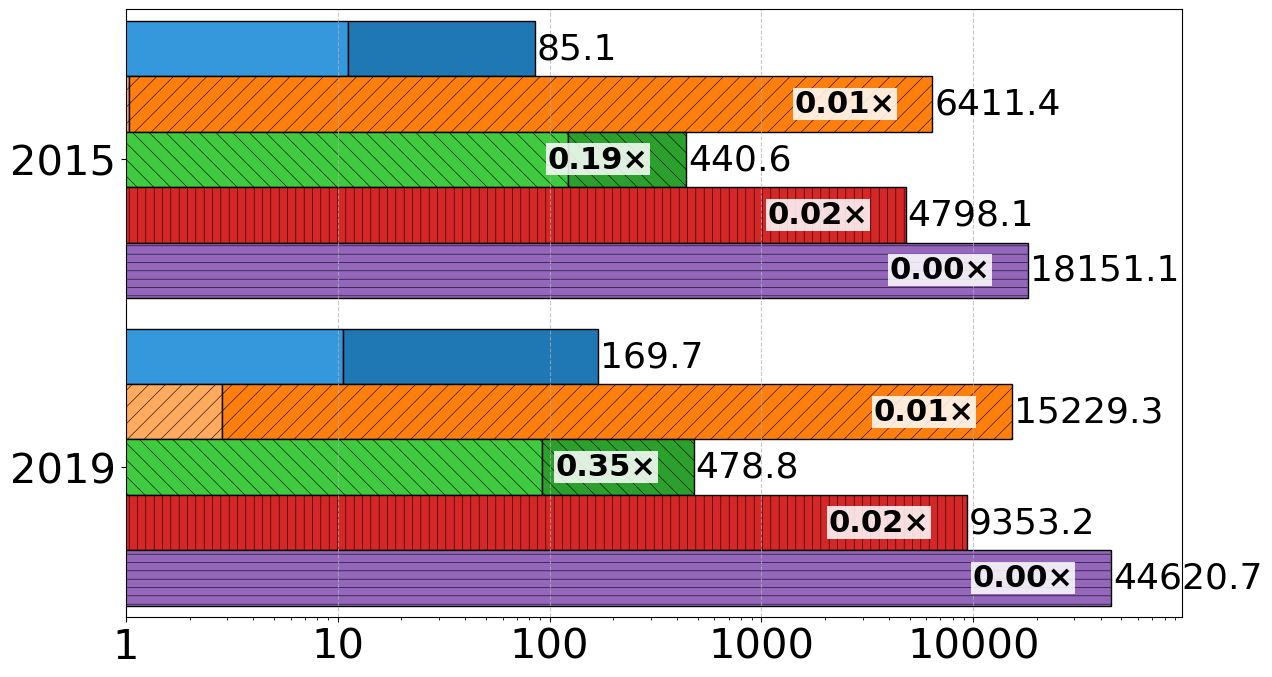


Generating plot for models trained in 2015...
Plot saved to plots/data_shift_2015.pdf


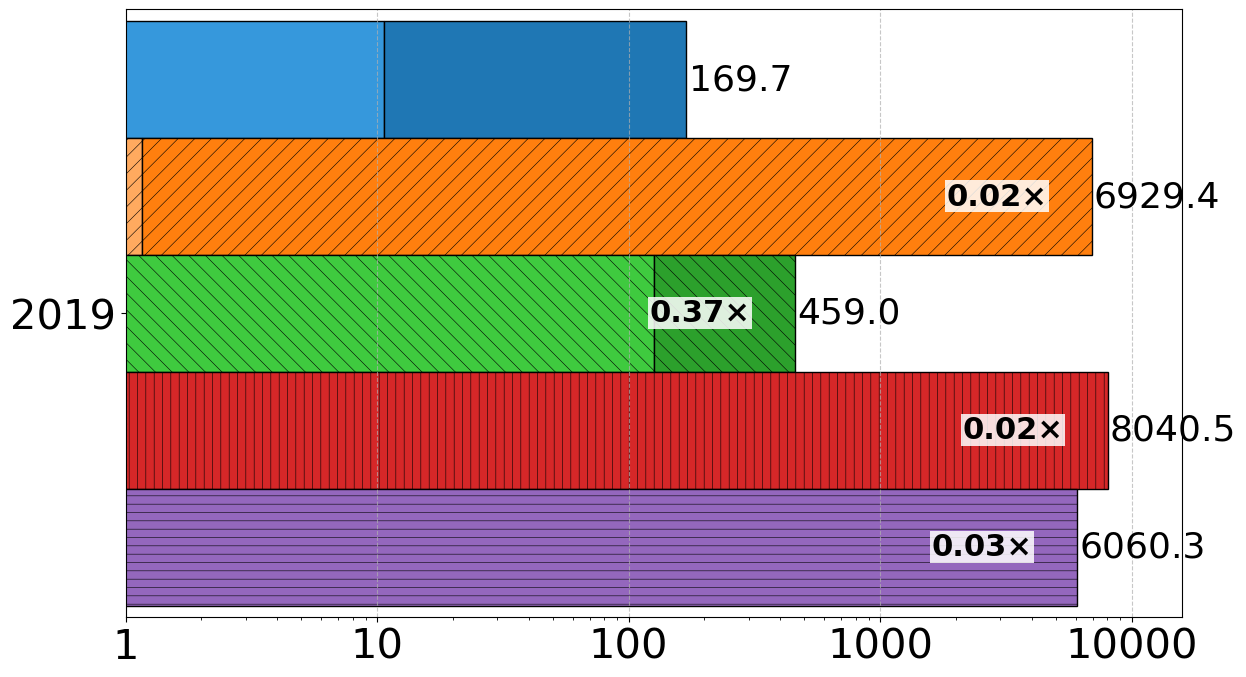

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import os

# Assume optimizer_colors, patterns, and adjust_lightness are already defined

def create_single_trained_year_plot(latency_data, inference_data, trained_year, title="Data Distribution Shift", log_scale=True, output_dir="plots", year="2011"):
    """
    Creates a single HORIZONTAL plot for a specific model training year,
    visually optimized for a compact figsize of (8, 6) with clean labels.
    """
    plt.rcParams['hatch.linewidth'] = 0.4
    plt.rcParams.update({'font.size': 24}) # Smaller base font size

    fig, ax = plt.subplots(figsize=(12, 8)) # Set the desired compact figure size

    lat_data = latency_data.get(trained_year)
    inf_data = inference_data.get(trained_year)
    
    examined_optimizers = [opt for opt in optimizer_colors.keys() if opt != "LERO"]

    if not lat_data or not inf_data:
        print(f"No data found for trained year {trained_year}. Skipping plot.")
        plt.close(fig)
        return

    if trained_year == "2011":
        eval_years = [y for y in ["2015", "2019"] if y in lat_data]
    elif trained_year == "2015":
        eval_years = [y for y in ["2019"] if y in lat_data]
    else:
        eval_years = sorted(list(lat_data.keys()))

    if not eval_years:
        ax.set_title(f"Trained {trained_year} (No relevant evaluation data)")
        ax.set_xticks([]); ax.set_yticks([])
        plt.close(fig)
        return

    num_optimizers = len(examined_optimizers)
    group_height = 0.9
    bar_height = group_height / num_optimizers
    
    y_groups = np.arange(len(eval_years))
    offset_per_optimizer = np.arange(len(examined_optimizers)) - (len(examined_optimizers) - 1) / 2

    for j, eval_year in enumerate(eval_years):
        pg_total = (lat_data[eval_year].get("Postgres", 0) + inf_data[eval_year].get("Postgres", 0)) or 1e-9

        for i, optimizer in enumerate(examined_optimizers):
            total = lat_data[eval_year].get(optimizer, 0) + inf_data[eval_year].get(optimizer, 0)
            ypos = y_groups[j] + offset_per_optimizer[i] * bar_height
            
            # (Plotting logic for bars and annotations remains the same)
            inf_time = inf_data[eval_year].get(optimizer, 0)
            exec_time = lat_data[eval_year].get(optimizer, 0)
            color = optimizer_colors[optimizer]
            light_color = adjust_lightness(color, 1.3)
            hatch = patterns[optimizer]
            ax.barh(ypos, inf_time, height=bar_height, color=light_color, edgecolor="black", hatch=hatch, align='center')
            ax.barh(ypos, exec_time, height=bar_height, left=inf_time, color=color, edgecolor="black", hatch=hatch, align='center')
            if total > 0:
                ax.text(total * 1.02, ypos, f"{total:.1f}", ha="left", va="center", fontsize=26)
            if optimizer != "Postgres" and total > 0:
                speedup = pg_total / total
                ax.text(total / 1.5, ypos, f"{speedup:.2f}×", ha='right', va='center', fontsize=22, 
                        fontweight='bold', color='black',
                        bbox=dict(facecolor='white', edgecolor='none', pad=1.0, alpha=0.85))

    # --- THIS IS THE KEY CHANGE ---
    ax.set_yticks(y_groups)
    plt.xticks(fontsize=30)
    ax.set_yticklabels(eval_years, fontsize=30) 
    ax.set_ylabel("", fontsize=10)
    # ax.set_xlabel("Total Time (s)", fontsize=10)
    ax.invert_yaxis()

    if log_scale:
        ax.set_xscale("log")
        ax.set_xlim(left=1)
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    ax.grid(True, axis="x", linestyle="--", alpha=0.7)
    
    optimizer_handles = [mpatches.Patch(facecolor=optimizer_colors[o], edgecolor="black", hatch=patterns[o], label=o) for o in examined_optimizers]
    exec_patch = mpatches.Patch(facecolor="gray", edgecolor="black", label="Execution Time")
    inf_patch = mpatches.Patch(facecolor="lightgray", edgecolor="black", label="Inference Time")

    # fig.legend(handles=optimizer_handles + [exec_patch, inf_patch],
    #            loc="upper center", bbox_to_anchor=(0.5, 1.12),
    #            ncol=4, fontsize=23, frameon=True,
    #            facecolor="white", edgecolor="black", fancybox=True, handlelength=1.5)

    # fig.suptitle(title, fontsize=12, y=1)
    plt.tight_layout() # Adjust rect for the new layout
    ax.margins(0.02)
    os.makedirs(output_dir, exist_ok=True)
    plt.subplots_adjust(left=0.1, right=0.98, top=0.88, bottom=0.12)
    filename = f"data_shift_{year}.pdf"
    fig.savefig(os.path.join(output_dir, filename), bbox_inches="tight")
    print(f"Plot saved to {os.path.join(output_dir, filename)}")
    plt.show()
    
print("\n----- Data Distribution Shift -----")
[latency_dict_dds, inference_dict_dds] = prepare_data(df, 'data_distribution_shift') # Subcategory 'stack'
if latency_dict_dds and inference_dict_dds:
    # Get the list of years models were trained on
    trained_years = sorted(latency_dict_dds.keys())
    
    for year in trained_years:
        # Create a specific title for each plot
        plot_title = f"Data Distribution Shift: Models Trained on {year} Data"
        
        print(f"\nGenerating plot for models trained in {year}...")
        
        # Call the new function for each trained year
        create_single_trained_year_plot(
            latency_dict_dds,
            inference_dict_dds,
            trained_year=year,
            title=plot_title,
            year=year
        )
else:
    print("Data for Data Distribution Shift not available. Cannot generate plots.")

### Takeaways

**FASTgres**: Struggled immensely with the new data distributions, since the context models it already knows are probably now giving very bad hints to the classic optimizer

**BAO**: Struggels with a similar problem but not as much, because bao incorporates live statistics from the database in its encoding